In [1]:
import gym
import numpy as np

import os

import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Taxi Environment

In [2]:
name = "Taxi-v3"
env = gym.make(name)
spec = gym.spec(name)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}")

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8


# Helper Functions

In [3]:
def evaluate_taxi(model, num_episodes=20):
    """
    Evaluate a RL agent
    :param model: the RL Agent
    :param num_episodes: number of episodes to evaluate it
    :return: Mean reward for the last num_episodes
    """
    all_episode_rewards = np.zeros((num_episodes))
    env = gym.make(name)
    env.seed(42)
    
    for i in range(num_episodes):
        episode_rewards = []
        frames = [] # for animation
        done = False
        obs = env.reset()
        while not done:
            action = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

            # Put each rendered frame into dict for animation
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': obs,
                'action': action,
                'reward': reward
                }
            )
        all_episode_rewards[i] = sum(episode_rewards)
    
    env.close()

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward, frames

In [4]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

# Q-Learning

In [5]:
class QLearningDiscrete:
    def __init__(self, env, max_frames=99, gamma=0.618, epsilon=1.0):
        """
        :param env: OpenAI RL environment to solve
        :param max_frames: Max number of iteration in a single gameplay
        :param gamma: Decay factor
        :param epsilon: Exploration term
        """
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.n
        self.Q = np.random.random((self.state_size, self.env.action_space.n))
        self.max_frames = max_frames
        self.gamma = gamma
        self.epsilon = epsilon


    def _bellman_equation(self, state, action, reward, next_state):
        """
        Update the Q-Learning table with discounted reward
        :param state: Current state of the environment.
        :param action: Action to be taken by the agent.
        :param reward: Reward perceived by the agent.
        :param next_state: Current state of the environment.
        """
        self.Q[state, action] = self.Q[state, action] + self.gamma * (reward + np.max(self.Q[next_state, ]) - self.Q[state, action])

    def _epsilon_decay(self, total_time):
        """
        Decay the exploration factor in training.
        :param total_time: max number of steps to play
        :return: new exploration factor
        """
        exploration_steps = total_time / 2
        epsilon_decay = (1 - 0.1) / exploration_steps
        return max(self.epsilon - epsilon_decay, 0.1)
    
    def predict(self, obs, training=True):
        """
        Q-Learning table lookup for decision making.
        :param obs: Current observation of the agent
        :param training: Boolean for if the agent is training
        :return: Action the agent will make.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            # Select a random action at random occurrences
            return self.env.action_space.sample()
        # Select optimal action
        return np.argmax(self.Q[obs, :])

    def learn(self, total_timesteps):
        """
        Q-Learning updating through game-playing
        :param total_timesteps: Max number of steps to play
        """
        timesteps = 0
        for episode in range(total_timesteps):
            # Reset variables for new game
            state = self.env.reset()
            # frame, cum_reward = 0, 0
            frame = 0
            done = False
            
            # Repeat until game-over or when too many frames have passed
            while not done and frame < self.max_frames:
                # Predict new decision
                action = self.predict(state)
                # Simulate decision
                next_state, reward, done, info = self.env.step(action)
                # Update Q table
                self._bellman_equation(state, action, reward, next_state)
                # Track the run
                state = next_state
                frame += 1
                # Decay exploration
                self.epsilon = self._epsilon_decay(total_timesteps)
            
            timesteps += frame
            if timesteps > total_timesteps:
                return None

## Random Agent

In [6]:
# Create log dir
log_dir = f"logs/{name}/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make(name)
# Logs will be saved in log_dir/
env = Monitor(env, log_dir)
env.seed(42)

In [7]:
model = QLearningDiscrete(env)

frames = evaluate_taxi(model)

Mean reward: -716.2 Num episodes: 20


In [8]:
print_frames(frames[1])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 200
State: 16
Action: 3
Reward: -1


## Agent Training

In [9]:
total_steps = 4e4
model.learn(total_timesteps=int(total_steps))

## Evaluation

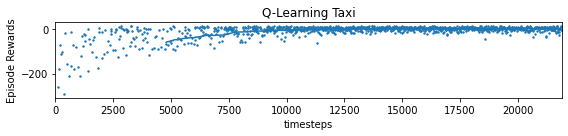

In [10]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], total_steps, results_plotter.X_TIMESTEPS, "Q-Learning Taxi")

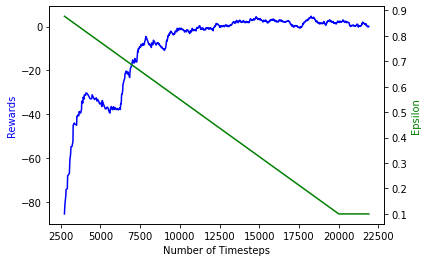

In [11]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y1 = ts2xy(load_results(log_folder), 'timesteps')
    y1 = moving_average(y1, window=50)
    # Truncate x
    x = x[len(x) - len(y1):]

    # Exploration epsilon values
    exploration_steps = total_steps / 2
    epsilon_decay = (1 - 0.1) / exploration_steps
    y2 = np.array([max(1 - epsilon_decay * time, 0.1) for time in range(int(total_steps))])[x[x < total_steps]]
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'b-')
    ax2.plot(x[x < total_steps], y2, 'g-')

    ax1.set_xlabel('Number of Timesteps')
    ax1.set_ylabel('Rewards', color='b')
    ax2.set_ylabel('Epsilon', color='g')

    plt.show()

plot_results(log_dir)

In [13]:
frames = evaluate_taxi(model)

Mean reward: 2.0 Num episodes: 20


In [14]:
print_frames(frames[1])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 85
Action: 5
Reward: 20
